In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
df = pd.read_csv('data.csv', index_col="Date")
#df = df["Close"]
#df.info()
#df["Close"].plot()
import warnings
warnings.filterwarnings("ignore")


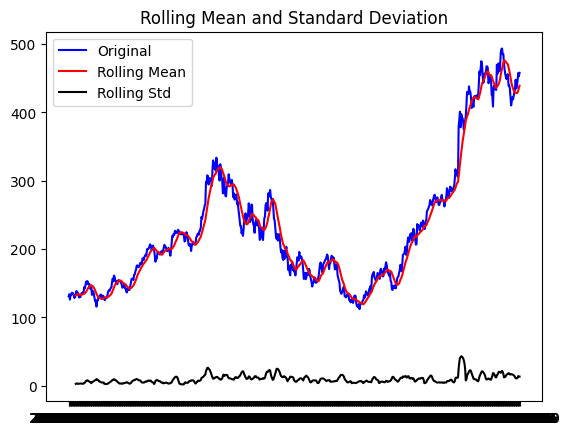

p-value: 0.9499013922396117


In [10]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    adf_test = adfuller(timeseries)
    print(f'p-value: {adf_test[1]}') #not stationary
    
test_stationarity(df["Close"])

<Figure size 640x480 with 0 Axes>

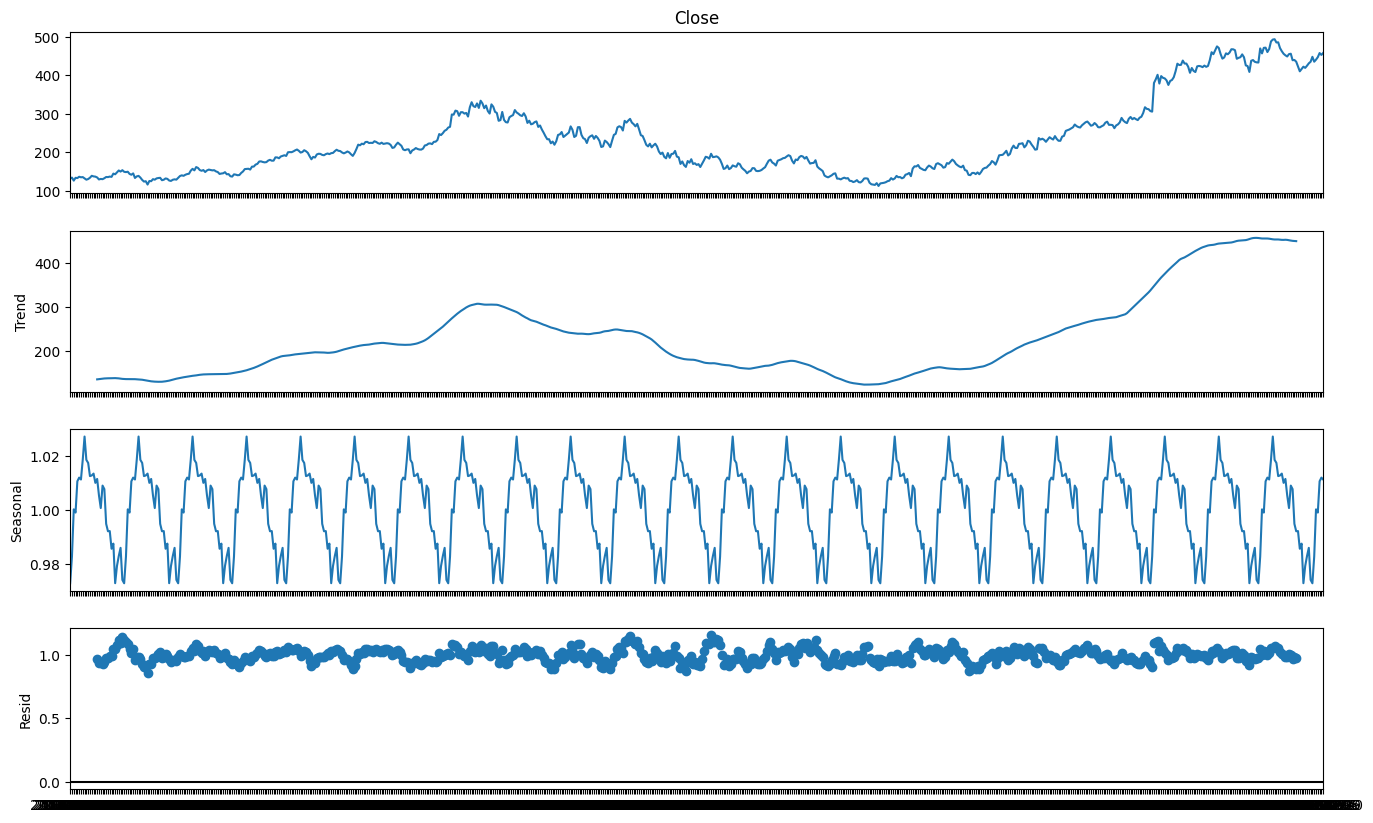

In [11]:
result = seasonal_decompose(df["Close"], model='multiplicative', period =30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

Differencing using log

p-value: 0.0


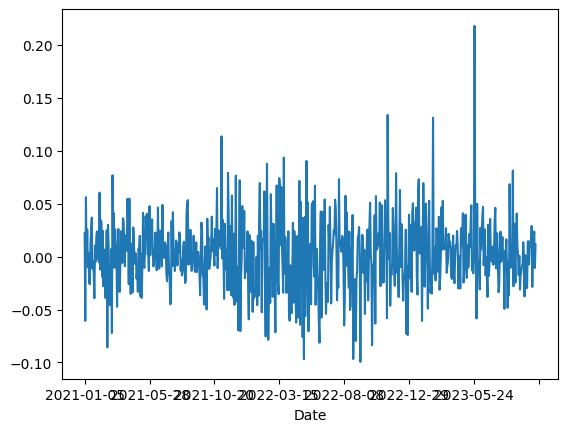

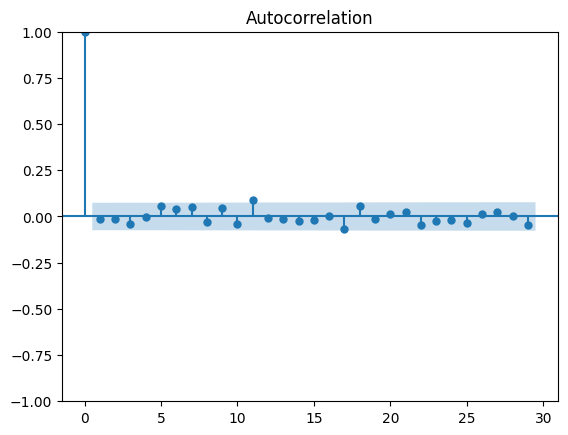

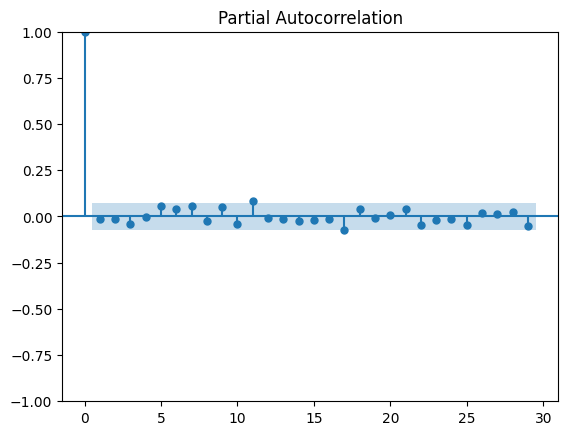

In [12]:
def make_logdiff(df):
    df_logdiff = np.log(df["Close"]) - np.log(df["Close"].shift(1))
    return df_logdiff.dropna()

df_logdiff = make_logdiff(df)
df_logdiff.plot()
acf_original = plot_acf(df_logdiff)
pacf_original = plot_pacf(df_logdiff)
adf_test = adfuller(df_logdiff)
print(f'p-value: {adf_test[1]}') #differenced data is stationary

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


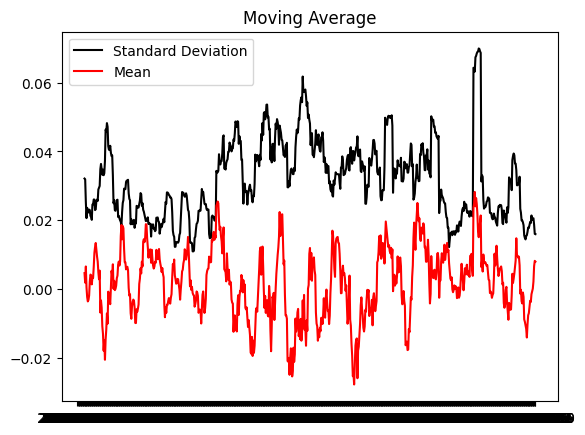

In [13]:
moving_avg = df_logdiff.rolling(12).mean()
std_dev = df_logdiff.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show() # looks p stationary to me

dataset split

In [14]:
train_data, test_data = df[3:int(len(df_logdiff)*0.9)].dropna(), df[int(len(df_logdiff)*0.9):].dropna()

Auto ARIMA

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3965.645, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3967.621, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3967.619, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3965.792, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3968.908, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.191 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  567
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1980.823
Date:                Sat, 21 Oct 2023   AIC                           3965.645
Time:                        22:54:35   BIC                           3974.322
Sample:                             0   HQIC                          3969.032
                                - 567                                       

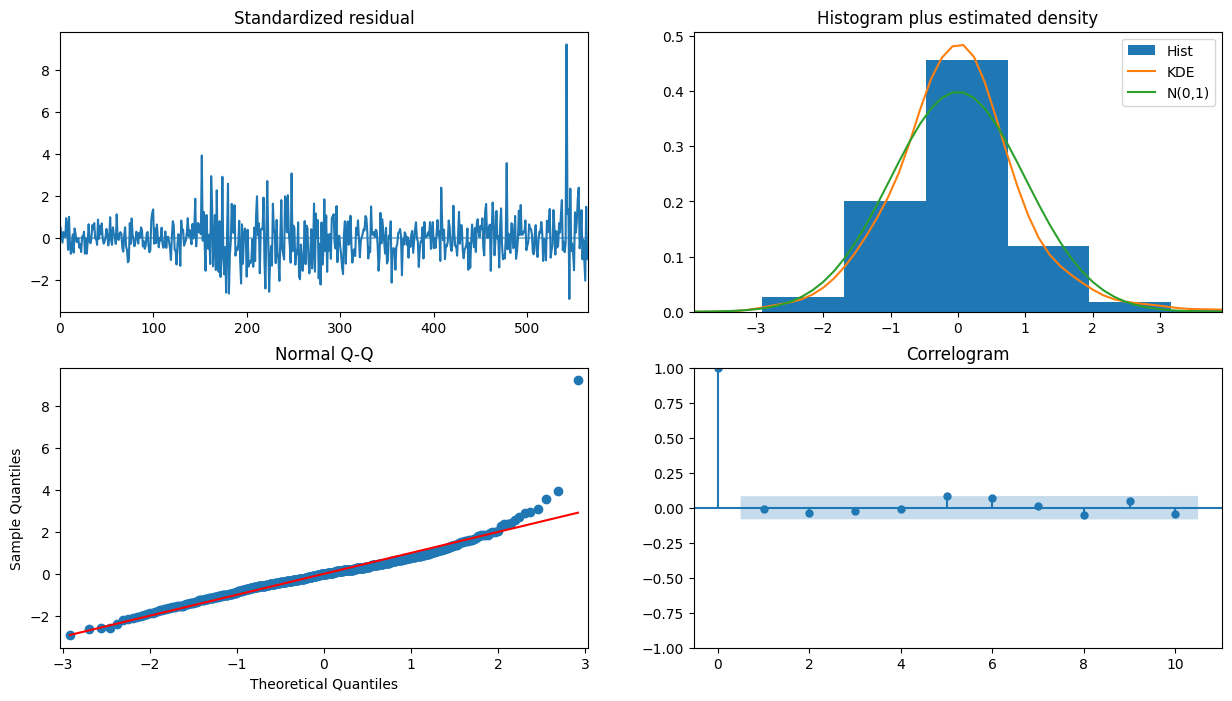

In [15]:
model_autoARIMA = auto_arima(train_data["Close"], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Modelling ARIMA (and ARIMAX)

- We choose p = q = 5 based on the ACF and PACF plots
- Tried including the other variables for regression, but turns out there was no difference in performance.

Root Mean Squared Error (ARIMA): 31.471023465683345
Root Mean Squared Error (ARIMAX): 31.471023465683345


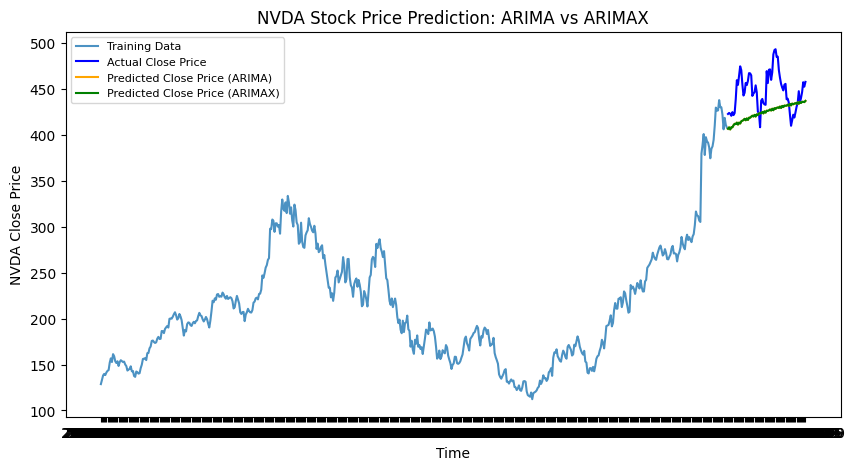

In [20]:
import statsmodels.api as sm

# ARIMA Model
model_arima = ARIMA(train_data["Close"], order=(5,1,5))
fitted_arima = model_arima.fit()
forecast_arima = fitted_arima.get_forecast(steps=len(test_data))
fc_arima = forecast_arima.predicted_mean

# Calculate RMSE for ARIMA
rmse_arima = np.sqrt(mean_squared_error(test_data["Close"], fc_arima))
print("Root Mean Squared Error (ARIMA):", rmse_arima)

# SARIMAX Model
endog = train_data['Close']
exog = train_data.drop('Close', axis=1).shift(1).fillna(method='bfill', inplace=True)  # removing the 'Close' column to use the rest as exogenous variables
exog_test = test_data.drop('Close', axis=1).shift(1).fillna(method='bfill', inplace=True) # give the preceding day's data for each day

model_sarimax = sm.tsa.SARIMAX(endog, exog=exog, order=(5,1,5))
fitted_sarimax = model_sarimax.fit(disp=False)
forecast_sarimax = fitted_sarimax.get_forecast(steps=len(test_data), exog=exog_test)
fc_sarimax = forecast_sarimax.predicted_mean

# Calculate RMSE for SARIMAX
rmse_sarimax = np.sqrt(mean_squared_error(test_data["Close"], fc_sarimax))
print("Root Mean Squared Error (ARIMAX):", rmse_sarimax)

# Plot both ARIMA and SARIMAX predictions together
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data["Close"], label='Training Data', alpha=0.8)
plt.plot(test_data["Close"], color='blue', label='Actual Close Price')
plt.plot(fc_arima, color='orange', label='Predicted Close Price (ARIMA)')
plt.plot(fc_sarimax, color='green', label='Predicted Close Price (ARIMAX)')
plt.title('NVDA Stock Price Prediction: ARIMA vs ARIMAX')
plt.xlabel('Time')
plt.ylabel('NVDA Close Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Predictions for submission:

- if the last day of data is the submission date, then the following prediction_df will be the predicted close prices of the next 14 days.

In [25]:
forecast_arima_extended = fitted_arima.get_forecast(steps=len(test_data) + 14)
fc_arima_extended = forecast_arima_extended.predicted_mean

# Save the last 14 days of predictions in prediction_df
prediction_df = pd.DataFrame(fc_arima_extended[-14:])
print(prediction_df)

     predicted_mean
638      435.821549
639      437.861971
640      436.358345
641      438.014733
642      437.398360
643      437.726880
644      438.466623
645      437.423334
646      439.235672
647      437.632304
648      439.534873
649      438.437279
650      439.333638
651      439.479976
